In [1]:
import numpy as np
from scipy import special, optimize
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15

In [2]:
#sigma = alpha in the code
def exponential_comp(t, thetaT, sigma, a):
    """gives the stuffs in the exponential"""
    tplus = (t - thetaT + a/2) * sigma / np.sqrt(2)
    tminus = (t - thetaT - a/2) * sigma / np.sqrt(2)
    return tplus, tminus

def d_erf(t, thetaT, sigma, a):
    """delta error function"""
    tplus, tminus = exponential_comp(t, thetaT, sigma, a)
    d_erf = 0.5 * (special.erf(tplus) - special.erf(tminus))
    return d_erf

def mu(x, y, thetaX, thetaY, alpha, beta, theta_I0, a, theta_bg):
    """image model for gaussian psf"""
    d_erfX = d_erf(x, thetaX, alpha, a)
    d_erfY = d_erf(y, thetaY, beta, a)
    muK = theta_I0 * d_erfX * d_erfY + theta_bg*a**2
    return muK
    
def dmu_dthetaX(x, y, thetaX, thetaY, alpha, beta,  a, theta_I0):
    """derivative of mu wrt thetaX"""
    d_erfY = d_erf(y, thetaY, beta, a)
    Xplus, Xminus = exponential_comp(x, thetaX, alpha, a)
    expo = np.exp(-Xminus**2) - np.exp(-Xplus**2)
    dmu_dthetaX = theta_I0*alpha/(np.sqrt(2*np.pi)) * expo * d_erfY
    return dmu_dthetaX

def dmu_dthetaY(x, y, thetaX, thetaY, alpha, beta, a, theta_I0):
    """derivative of mu wrt thetaY"""
    d_erfX = d_erf(x, thetaX, alpha, a)
    Yplus, Yminus = exponential_comp(y, thetaY, beta, a)
    expo = np.exp(-Yminus**2) - np.exp(-Yplus**2)
    dmu_dthetaY = theta_I0*beta/(np.sqrt(2*np.pi)) * expo * d_erfX
    return dmu_dthetaY

def dmu_dthetaI0(x, y, thetaX, thetaY, alpha, beta, a):
    """derivative of mu wrt thetaI0"""
    d_erfX = d_erf(x, thetaX, alpha, a)
    d_erfY = d_erf(y, thetaY, beta, a)
    dmu_dthetaI0 = d_erfY*d_erfX
    return dmu_dthetaI0

def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d
    
def derf_dsigma(t, thetaT, sigma, a):
    """derivative of delta error func wrt sigma, sigma=1/stddev"""
    tplus, tminus = exponential_comp(t, thetaT, sigma, a)
    der_erf = 1/np.sqrt(np.pi) * ((np.exp(-tminus**2) * tminus/sigma) - (np.exp(-tplus**2) * tplus/sigma))
    return der_erf

def dmu_dalpha(x, y, thetaX, thetaY, a, alpha, beta, theta_I0):
    """derivative of image model wrt sigma, sigma=1/stddev"""
    d_erfY = d_erf(y, thetaY, beta, a)
    derfX_dsigma = derf_dsigma(x, thetaX, alpha, a)
    dmu_dalpha = theta_I0 * derfX_dsigma * d_erfY
    return dmu_dalpha

def dmu_dbeta(x, y, thetaX, thetaY, a, alpha, beta, theta_I0):
    """derivative of image model wrt sigma, sigma=1/stddev"""
    d_erfX = d_erf(x, thetaX, alpha, a)
    derfY_dsigma = derf_dsigma(y, thetaY, beta, a)
    dmu_dbeta = theta_I0 * derfY_dsigma * d_erfX 
    return dmu_dbeta

    
def takeDer(para, x, y, thetaX, thetaY, alpha, beta, a, theta_I0):
    """take derivatives options"""
    if para == "thetaX":
        der = dmu_dthetaX(x, y, thetaX, thetaY, alpha, beta, a, theta_I0)
    elif para == "thetaY":
        der = dmu_dthetaY(x, y, thetaX, thetaY, alpha, beta, a, theta_I0)
    elif para == "thetaI0":
        der = dmu_dthetaI0(x, y, thetaX, thetaY, alpha, beta, a)
    elif para == "thetabg":
        der = dmu_dthetabg(a)
    elif para == "alpha":
        der = dmu_dalpha(x, y, thetaX, thetaY, a, alpha, beta, theta_I0)
    elif para == "beta":
        der = dmu_dbeta(x, y, thetaX, thetaY, a, alpha, beta, theta_I0)
    return der
    
def fisher(xmax, ymax, thetaX, thetaY, alpha, beta, a, theta_I0, theta_bg):
    """calculate fisher matrix"""
    para = ["thetaX", "thetaY", "thetaI0","thetabg", "alpha", "beta"]
    n = len(para)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    mus = mu(xs, ys, thetaX, thetaY, alpha, beta, theta_I0, a, theta_bg)
    
    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(para[i], xs, ys, thetaX,\
                                                 thetaY, alpha, beta, a, theta_I0) * 
            takeDer(para[j], xs, ys, thetaX, thetaY, alpha, beta, a, theta_I0))
    return fisher

def crlb(xmax, ymax, thetaX, thetaY, alpha, beta, a, theta_I0, theta_bg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, thetaX, thetaY, alpha, beta, a, theta_I0, theta_bg)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    return crlbs

alpha=3, beta=2, xmax=24, bg=1, N=500


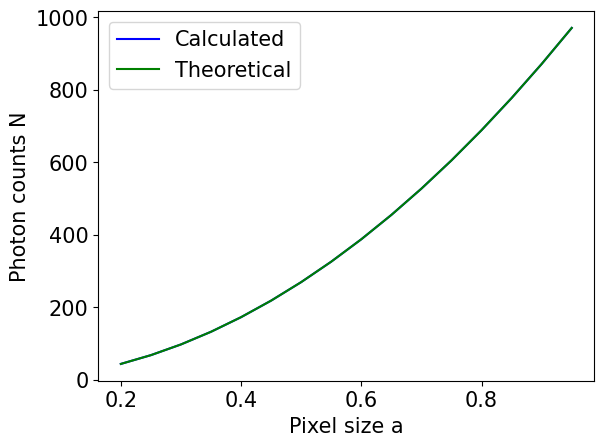

In [4]:
n = 20
alpha = 3
beta = 2
xmax = alpha*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
thetabg = 1
N = 500

x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)

plt.rcParams["font.size"] = 15
a = np.arange(0.2,1,0.05)
m = [np.sum(mu(xs, ys, thetaX, thetaY, 1/alpha, 1/beta, N, a[i], thetabg)) for i in range(len(a))]
mT = a**2*thetabg*xmax**2+N*a**2

print(f"alpha={alpha}, beta={beta}, xmax={xmax}, bg={thetabg}, N={N}")
plt.plot(a,m,"b", label="Calculated")
plt.plot(a,mT,"g", label="Theoretical")
plt.xlabel("Pixel size a")
plt.ylabel("Photon counts N")
plt.legend();

panel0, image: 268.99, true: 269.00
panel1, image: 43.04, true: 43.04
panel2, image: 43.04, true: 43.04


''

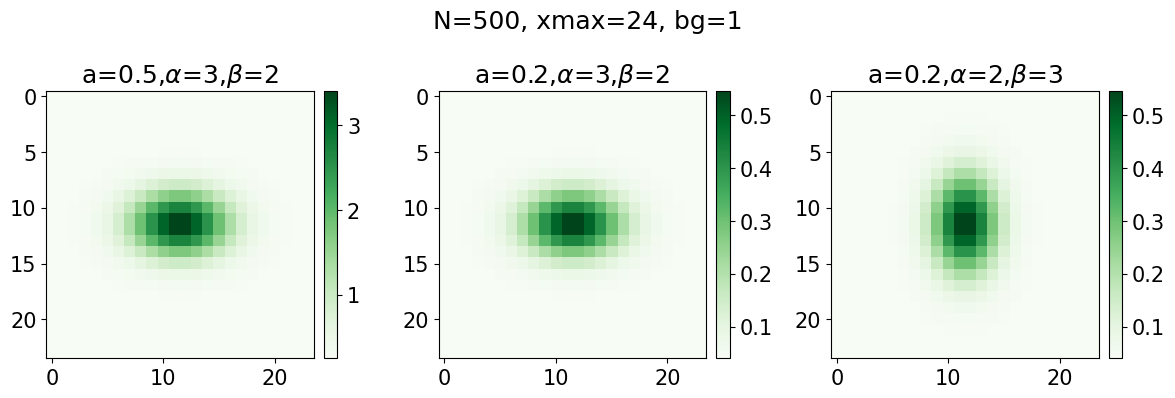

In [9]:
n = 20
alpha = np.array([3,3,2])
beta = np.array([2,2,3])
xmax = np.max(alpha)*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = [0.5,0.2,0.2] 
thetabg = 1
N = 500


fig,ax = plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    x,y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    m = mu(xs, ys, thetaX, thetaY, 1/alpha[i], 1/beta[i], N, a[i], thetabg)
    im0 = ax[i].imshow(m,cmap="Greens")
    div0 = make_axes_locatable(ax[i])
    cax0 = div0.append_axes("right", size="5%", pad=0.1)
    cbr0 = plt.colorbar(im0, cax=cax0, orientation="vertical")
    ax[i].set_title(f"a={a[i]},$\\alpha$={alpha[i]},$\\beta$={beta[i]}")
    img = np.sum(m)
    true = a[i]**2*thetabg*xmax**2 + N*a[i]**2
    print(f"panel{i}, image: {img:.2f}, true: {true:.2f}")
fig.suptitle(f"N={N}, xmax={xmax}, bg={thetabg}")
fig.tight_layout()
;

In [7]:
# Non-rotated
n = 20
alpha = 2
beta = 2
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2 
thetabg = 1e-5
N = 500

crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a, N, thetabg)

[0.20017742513949402,
 0.20017742513949402,
 12500.248771795146,
 1.1837411822220796e-06,
 0.006264217682064745,
 0.006264217682064744]

In [18]:
col = ["var(x)", "var(y)", "var(N)", "var(b)", "var(alpha)","var(beta)"]
n = 20
alpha = 3
beta = 2
xmax = alpha*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2 
thetabg = 1

#-----------vary N
N = np.arange(100, 1000, n)
crlbs = [crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a, N[i], thetabg) for i in range(len(N))]
df = pd.DataFrame(crlbs, columns=col)


#----------vary bg
b = np.linspace(0.01,1,25)
crlbs_b = [[crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a, N[i], b[j]) for i in range(len(N))] \
           for j in range(len(b))]

#----------vary source positions x0,y0
thetaX_oc = np.arange(0,xmax)
thetaY_oc = np.arange(0,ymax)
N_oc = 500
crlbs_oc = [crlb(xmax, ymax, thetaX_oc[i], thetaY_oc[i], 1/alpha, 1/beta, a, N_oc, thetabg) for i in range(len(thetaX_oc))]
df_oc = pd.DataFrame(crlbs_oc, columns=col)

#----------get back circle bounds
alpha_ss = 2
beta_ss = 2
crlbs_ss = [crlb(xmax, ymax, thetaX, thetaY, 1/alpha_ss, 1/beta_ss, a, N[i], thetabg) for i in range(len(N))]
df_ss = pd.DataFrame(crlbs_ss, columns=col)


In [21]:
print(f'alpha={alpha}, beta={beta}, xmax={xmax}, a={a}, bg={thetabg}')
#-------------Create figure
fig = make_subplots(rows=2, cols=2, horizontal_spacing=0.17,
                  subplot_titles=("CRLB vs. 1/N, source at center", 
                                  "CRLB vs. 1/N for varying b", 
                                  "x0 dependence, off-center source",
                                  "y0 dependence, off-center source"))
#------------vary N
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            mode="markers",
            marker=dict(color="darkseagreen"),
            x=1/N,
            y=df["var(x)"]+df["var(y)"]),
        row=1, col=1
    )

#----------vary bg
for i in range(len(b)):
    df_b = pd.DataFrame(crlbs_b[i], columns=col)
    fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="darkseagreen", width=4),
            name="b = " + str(b[i]),
            x=1/N,
            y=df_b["var(x)"]+df_b["var(y)"]),
        row=1, col=2
    )

#----------vary source positions x0
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="darkseagreen", width=4),
            x=thetaX_oc,
            y=df_oc["var(x)"]+df_oc["var(y)"]),
        row=2, col=1
    )
#----------vary source positions y0
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="darkseagreen", width=4),
            x=thetaY_oc,
            y=df_oc["var(x)"]+df_oc["var(y)"]),
        row=2, col=2
    )

#----------formatting
fig.update_xaxes(title_text="1/N", row=1, col=1)
fig.update_yaxes(title_text="var(x)+var(y)", row=1, col=1)

fig.update_xaxes(title_text="1/N", row=1, col=2)
fig.update_yaxes(title_text="var(x)+var(y)", row=1, col=2)

fig.update_xaxes(title_text="$x_0$", row=2, col=1)
fig.update_yaxes(title_text="var(x)+var(y)", row=2, col=1)

fig.update_xaxes(title_text="$y_0$", row=2, col=2)
fig.update_yaxes(title_text="var(x)+var(y)", row=2, col=2)

fig.update_layout(height=700, template = "ggplot2", margin=dict(l=100, r=100, t=100, b=80))
fig.show()

alpha=3, beta=2, xmax=36, a=0.2, bg=1


alpha=3, beta=2, a=0.2, bg=1e-05

for X: experiment: var(x) = 225.1469/N + -0.0001
for X: theory    : var(x) = 224.99999999999994/N + const/a^2

for Y: experiment: var(y) = 100.1116/N + -0.0000
for Y: theory    : var(y) = 99.99999999999999/N + const/a^2


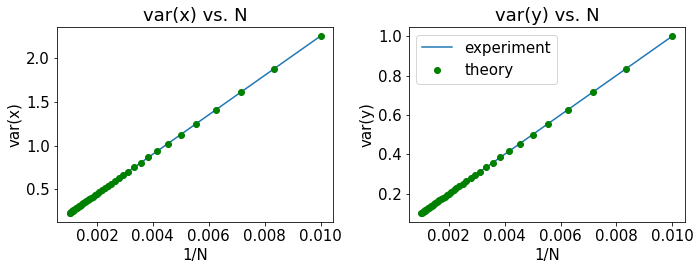

In [16]:
col = ["var(x)", "var(y)", "var(N)", "var(b)", "var(alpha)","var(beta)"]
#----------small background case
plt.rcParams['font.size']=15
def line(x,m,b):
    return m*x+b

alpha = 3
beta = 2
xmax = alpha*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
thetabg = 1e-5
a = 0.2
N = np.arange(100, 1000, 20)

crlbs = [crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a, N[i], thetabg) for i in range(len(N))]        
df = pd.DataFrame(crlbs, columns=col)       
varX = df["var(x)"]
varY = df["var(y)"]

poptX, pcov = optimize.curve_fit(line, 1/N, varX)
poptY, pcov = optimize.curve_fit(line, 1/N, varY)

fig,ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(1/N,line(1/N, poptX[0], poptX[1]), label="experiment")
ax[0].plot(1/N, line(1/N, alpha**2/a**2, 0),"go",label="theory")
ax[0].set_xlabel("1/N")
ax[0].set_ylabel("var(x)")
ax[0].set_title("var(x) vs. N")

ax[1].plot(1/N,varY, label="experiment")
ax[1].plot(1/N, line(1/N, beta**2/a**2, 0),"go",label="theory")
ax[1].set_xlabel("1/N")
ax[1].set_ylabel("var(y)")
ax[1].set_title("var(y) vs. N")
ax[1].legend()



fig.tight_layout()
;

print(f"alpha={alpha}, beta={beta}, a={a}, bg={thetabg}")
print()
print(f"for X: experiment: var(x) = {poptX[0]:.4f}/N + {poptX[1]:.4f}")
print(f"for X: theory    : var(x) = {alpha**2/a**2}/N + const/a^2")
print()
print(f"for Y: experiment: var(y) = {poptY[0]:.4f}/N + {poptY[1]:.4f}")
print(f"for Y: theory    : var(y) = {beta**2/a**2}/N + const/a^2")

$$
var(X) =\frac{width^2}{a^2} \frac{1}{N}
$$
$$
var(Y) =\frac{height^2}{a^2} \frac{1}{N}
$$

In [50]:
#----------vary alpha
alpha = np.linspace(3,6,50)
beta = 2
xmax = alpha*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2 
thetabg = [1, 1e-4]
N = 500

crlbs_alpha = [[crlb(xmax[i], ymax[i], thetaX[i], thetaY[i], 1/alpha[i], 1/beta, \
                     a, N, thetabg[j]) for i in range(len(alpha))]for j in range(len(thetabg))]

#----------vary beta
alpha_beta = 6
beta = np.linspace(2,5,50)
xmax = alpha_beta*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2 
thetabg = [1, 1e-4]
N = 500

crlbs_beta = [[],[]]
betas = [[],[]]
for j in range(2):
    for i in range(len(beta)):
        try:
            crlbs_beta[j].append(crlb(xmax, ymax, thetaX, thetaY, 1/alpha_beta, 1/beta[i], \
                                         a, N, thetabg[j]))
            betas[j].append(beta[i])
        except:
            print("singular at beta=%.3f" %beta[i])   

In [56]:
# Create figure
fig = make_subplots(rows=2, cols=2, horizontal_spacing=0.17,
                  subplot_titles=(
                                  "alpha dependence, b=1",
                                  "alpha dependence, b=1e-4",
                                 "beta dependence, b=1",
                                  "beta dependence, b=1e-4"))


#---------vary alpha, noisy
df_alpha = pd.DataFrame(crlbs_alpha[0], columns=col)
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="olivedrab", width=4),
            x=alpha,
            y=df_alpha["var(x)"]),
        row=1, col=1
    )
#---------vary alpha, low noise
df_alpha = pd.DataFrame(crlbs_alpha[1], columns=col)
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="olivedrab", width=3),
            x=alpha**2/a**2/N,
            y=df_alpha["var(x)"]),
        row=1, col=2
    )

#---------vary beta, noisy
df_beta = pd.DataFrame(crlbs_beta[0], columns=col)
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="steelblue", width=4),
            x=betas[0],
            y=df_beta["var(y)"]),
        row=2, col=1
    )
#---------vary beta, low noise
df_beta = pd.DataFrame(crlbs_beta[1], columns=col)
fig.add_trace(
        go.Scatter(
            visible=True,
            showlegend=False,
            line=dict(color="steelblue", width=3),
            x=np.array(betas[1])**2/a**2/N,
            y=df_beta["var(y)"]),
        row=2, col=2
    )



fig.update_xaxes(title_text="$\\alpha$", row=1, col=1)
fig.update_yaxes(title_text="var(x)", row=1, col=1)

fig.update_xaxes(title_text="$\\alpha^2/a^2N$", row=1, col=2)
fig.update_yaxes(title_text="var(x)", row=1, col=2)

fig.update_xaxes(title_text="$\\beta$", row=2, col=1)
fig.update_yaxes(title_text="var(x)", row=2, col=1)

fig.update_xaxes(title_text="$\\beta^2/a^2N$", row=2, col=2)
fig.update_yaxes(title_text="var(y)", row=2, col=2)

fig.update_layout(height=700, template = "ggplot2", margin=dict(l=100, r=100, t=100, b=80))
fig.show()

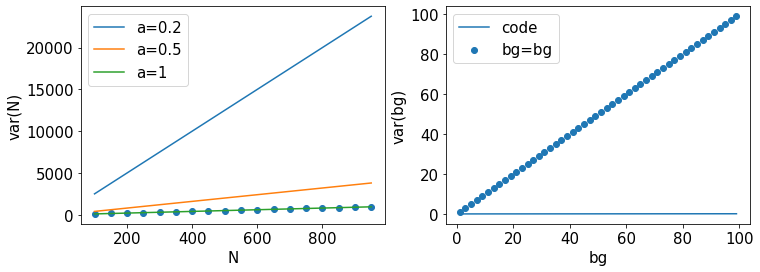

In [76]:
#-----------vary N
n = 50
alpha = 3
beta = 2
xmax = alpha*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = [0.2,0.5,1]
thetabg = 1e-10

N = np.arange(100, 1000, n)
crlbs = [[crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a[j], N[i], thetabg) for i in range(len(N))] for j in range(3)]
dfs = [pd.DataFrame(crlbs[i], columns=col) for i in range(3)]
varN = [dfs[i]['var(N)'] for i in range(3)]

fig, ax = plt.subplots(1,2,figsize=(12,4))

[ax[0].plot(N, varN[i], label=f"a={a[i]}") for i in range(3)]
ax[0].scatter(N,N)
ax[0].legend()

#-----------vary bg
alpha = 3
beta = 2
xmax = alpha*12
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 1 
thetabg = np.arange(1,100,2)
N_bg = 500
crlbs_bg = [crlb(xmax, ymax, thetaX, thetaY, 1/alpha, 1/beta, a, N_bg, thetabg[i]) for i in range(len(thetabg))]
df_bg = pd.DataFrame(crlbs_bg, columns=col)
varBG = df_bg["var(b)"]

ax[1].plot(thetabg, varBG, label="code")
ax[1].scatter(thetabg,thetabg, label="bg=bg")
ax[1].legend()

ax[0].set_xlabel("N")
ax[0].set_ylabel("var(N)")

ax[1].set_xlabel("bg")
ax[1].set_ylabel("var(bg)");